# Generation walkthrough for scldm

This notebook demonstrates single-process data generation using Hydra configs. It mirrors the logic used in our scripts while keeping everything runnable in a notebook. Each section briefly explains the step and then executes the equivalent code.

What you'll see:
- Compose the Hydra config from `experiments/configs/generation.yaml`
- Instantiate the datamodule and model (generator)
- Optionally load model weights from a checkpoint
- Build a PyTorch Lightning trainer (callbacks/loggers from config)
- Run generation and save an `.h5ad` output


# Install scldm and download artifacts needed for generation

In [1]:
import os
import pathlib

# keep track of the repo root so we know where artifacts and configs are
try:
    # make sure we re-use the path we found the first time if this is run without restarting the kernel
    NOTEBOOK_PATH = NOTEBOOK_PATH
except NameError:
    NOTEBOOK_PATH = pathlib.Path().resolve()
REPO_ROOT = NOTEBOOK_PATH.parent.parent  # assuming this notebook is in docs/notebooks
print(f"{REPO_ROOT=}")
os.chdir(REPO_ROOT)

%pip install -e . cellarium-ml@git+https://github.com/cellarium-ai/cellarium-ml.git

from scldm.download_artifacts import download_artifacts

download_artifacts(REPO_ROOT / "_artifacts", groups={"datasets", "fm_observational"})

REPO_ROOT=PosixPath('/home/ubuntu/scldm')
  Cloning https://github.com/cellarium-ai/cellarium-ml.git to /tmp/pip-install-v5vk54bo/cellarium-ml_5dde279fdd2a495597c1f7cbb6a21e44
  Running command git clone --filter=blob:none --quiet https://github.com/cellarium-ai/cellarium-ml.git /tmp/pip-install-v5vk54bo/cellarium-ml_5dde279fdd2a495597c1f7cbb6a21e44
  Resolved https://github.com/cellarium-ai/cellarium-ml.git to commit 58bc81b1e4ff51ceef51664bd99aed8af229b412
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Obtaining file:///home/ubuntu/scldm
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for scldm (pyproject.toml) ... done
  Created wheel for scldm: filename=scldm-0.0.1.dev11+g087f

## Environment and imports

This cell sets up environment variables and imports the same Python modules used by the script. We keep the imports local to cells to mimic script scoping and to avoid side effects until needed.
source 

In [2]:
import os
import pathlib

# Match script behavior
os.environ["HYDRA_FULL_ERROR"] = "1"

import hydra
from omegaconf import OmegaConf

from scldm._utils import (
    process_generation_output,
    process_inference_output,
    remap_config,
    remap_pickle,
)

# Register useful resolver used in configs
try:
    OmegaConf.register_new_resolver("eval", eval)
except ValueError:
    # Already registered
    pass
print("OmegaConf resolver 'eval' registered.")

OmegaConf resolver 'eval' registered.


## Compose the Hydra config

We compose the configuration directly in-notebook using Hydra's `initialize`/`compose` APIs, pointing to `experiments/configs/`. Here we load `generation.yaml`; interpolations and defaults resolve as they would in the scripts.


In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf

# Initialize Hydra to read from experiments/configs - use relative path
with initialize(config_path="../../experiments/configs", version_base="1.2"):
    cfg = compose(
        config_name="generation.yaml",
        overrides=[
            "~training.logger.wandb",
            "datamodule.datamodule.test_batch_size=32",  # reduce batch size to avoid GPU OOM errors
        ],
    )

print(OmegaConf.to_yaml(cfg)[:500])  # preview

paths:
  base_data_path: _artifacts/datasets
  base_release_path: _artifacts/
  base_experiment_path: experiments/
  dataset_paths:
    dentate_gyrus:
      train: ${paths.base_data_path}/dentategyrus_train.h5ad
      test: ${paths.base_data_path}/dentategyrus_test.h5ad
      config: ${paths.base_release_path}/fm_observational/dentate_gyrus.yaml
      ckpt: ${paths.base_release_path}/fm_observational/dentate_gyrus.ckpt
      mu_size_factor: ${paths.base_release_path}/fm_observational/dentate_gyr


## Instantiate datamodule and model

We load the module configuration from `cfg.config_file`, apply `remap_config`, and instantiate:
- the {class}`~scldm.datamodule.DataModule` via `hydra.utils.instantiate(cfg.datamodule.datamodule)`
- the model specified in the config (used here for generation)

In [4]:
from omegaconf import OmegaConf

# Module config file path from composed cfg
module_ckpt_path = pathlib.Path(cfg.ckpt_file)
module_config_path = pathlib.Path(cfg.config_file)

print(f"Loading module config from: {module_config_path}")
module_config = OmegaConf.load(module_config_path)
remap_config(module_config)

print("Instantiating datamodule...")
datamodule = hydra.utils.instantiate(cfg.datamodule.datamodule)

print("Instantiating model from config...")
module = hydra.utils.instantiate(module_config.model.module)

print("Datamodule and model ready.")

Loading module config from: _artifacts/fm_observational/dentate_gyrus.yaml
Instantiating datamodule...
Instantiating model from config...
Datamodule and model ready.


In [5]:
import torch

if module_ckpt_path.exists():
    print(f"Loading checkpoint weights from {module_ckpt_path}")
    checkpoint = torch.load(module_ckpt_path, map_location="cpu", pickle_module=remap_pickle, weights_only=False)
    state_dict = checkpoint["state_dict"] if isinstance(checkpoint, dict) and "state_dict" in checkpoint else checkpoint

    module_keys = set(module.state_dict().keys())
    filtered_state_dict = {k: v for k, v in state_dict.items() if k in module_keys}

    loaded = len(filtered_state_dict)
    skipped = len(state_dict) - loaded
    missing = len(module_keys) - loaded

    if skipped:
        print(f"Skipping {skipped} keys not present in module")
    if missing:
        print(f"Module has {missing} keys not in checkpoint")
    print(f"Loading {loaded} matching keys from checkpoint")

    module.load_state_dict(filtered_state_dict, strict=False)
else:
    print(f"Checkpoint file not found: {module_ckpt_path}")

Loading checkpoint weights from _artifacts/fm_observational/dentate_gyrus.ckpt
Skipping 154 keys not present in module
Loading 324 matching keys from checkpoint


## Build the Trainer, callbacks, and loggers

We instantiate callbacks and loggers from the training section of the config and construct a PyTorch Lightning `Trainer` with the same options used for generation runs. Seeding and runtime tweaks match the script behavior.


In [6]:
import pytorch_lightning as pl
import torch

# Match script's runtime setup
torch.set_float32_matmul_precision("high")
torch._dynamo.config.capture_scalar_outputs = True
pl.seed_everything(cfg.seed)

print("Instantiating callbacks and loggers from config...")
callbacks_list = []
for cb_cfg in getattr(cfg.training, "callbacks", {}).values():
    callbacks_list.append(hydra.utils.instantiate(cb_cfg, _partial_=False))

loggers_list = []
for lg_cfg in getattr(cfg.training, "logger", {}).values():
    loggers_list.append(hydra.utils.instantiate(lg_cfg, _partial_=False))

# Trainer is provided as a partial in config; instantiate callable first
trainer_ctor = hydra.utils.instantiate(cfg.training.trainer)  # partial

trainer = trainer_ctor(
    devices=1,
    strategy="auto",
    logger=loggers_list if len(loggers_list) > 0 else False,
    callbacks=callbacks_list,
)

# Optional cache tuning, as in script
torch.cuda.empty_cache()
torch._dynamo.config.cache_size_limit = 1000

print("Trainer ready.")

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Instantiating callbacks and loggers from config...
Trainer ready.


## Run generation and save outputs

This mirrors the script's predict flow for generation:
- Set the module to eval and call `datamodule.setup("predict")`
- Call `trainer.predict(module, datamodule=datamodule)`
- Post-process with {func}`~scldm._utils.process_generation_output` to build an `.h5ad`
- Save results to `cfg.inference_path` with dataset and type suffix

In [7]:
# Predict flow
if cfg.model.module.generation_args is not None or cfg.model.module.inference_args is not None:
    module.eval()
    datamodule.setup("predict")
    output = trainer.predict(module, datamodule=datamodule)

    if cfg.model.module.generation_args is not None:
        adata = process_generation_output(output, datamodule)
    else:
        adata = process_inference_output(output, datamodule)

    inference_type = "generated" if cfg.model.module.generation_args is not None else "inference"
    adata.obs["generation_idx"] = cfg.dataset_generation_idx
else:
    print("No generation_args or inference_args specified in the config; skipping predict.")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/venv_scldm/lib/python3.11/site-packages/cellarium/ml/utilities/distributed.py:52: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(
/home/ubuntu/venv_scldm/lib/python3.11/site-packages/pytorch_lightning/utilities/data.py:123: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |                                                                                                 …

WARNING  Inferred size-factor condition key 'clusters' for independent sampling.                                   
INFO     Processing generation output                                                                              


/home/ubuntu/venv_scldm/lib/python3.11/site-packages/cellarium/ml/utilities/distributed.py:52: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(


## Customization tips

- To switch datasets or models, adjust overrides when composing the config or edit `experiments/configs/generation.yaml`.
- Control behavior via `model.module.generation_args` (default here). `inference_args` can be used when running inference instead.
- Output location and naming are controlled by `inference_path`, `datamodule.dataset`, and `dataset_generation_idx`.


In [8]:
import anndata as ad
import scanpy as sc

adata_test = ad.read_h5ad(pathlib.Path(cfg.datamodule.datamodule.test_adata_path))
adata_test.X = adata_test.layers["X_counts"].copy()
adata_test.obs["dataset"] = "test"

## Visualizing generated vs test data

We compare generated cells with the held-out test set using UMAP to assess overlap and cluster structure.

In [9]:
adata_conditional = ad.concat([adata_test, adata[adata.obs.dataset == "generated_conditional"]], axis=0)
adata_unconditional = ad.concat([adata_test, adata[adata.obs.dataset == "generated_unconditional"]], axis=0)

sc.pp.normalize_total(adata_conditional)
sc.pp.log1p(adata_conditional)
sc.pp.pca(adata_conditional)
sc.pp.neighbors(adata_conditional)
sc.tl.umap(adata_conditional)

sc.pp.normalize_total(adata_unconditional)
sc.pp.log1p(adata_unconditional)
sc.pp.pca(adata_unconditional)
sc.pp.neighbors(adata_unconditional)
sc.tl.umap(adata_unconditional)

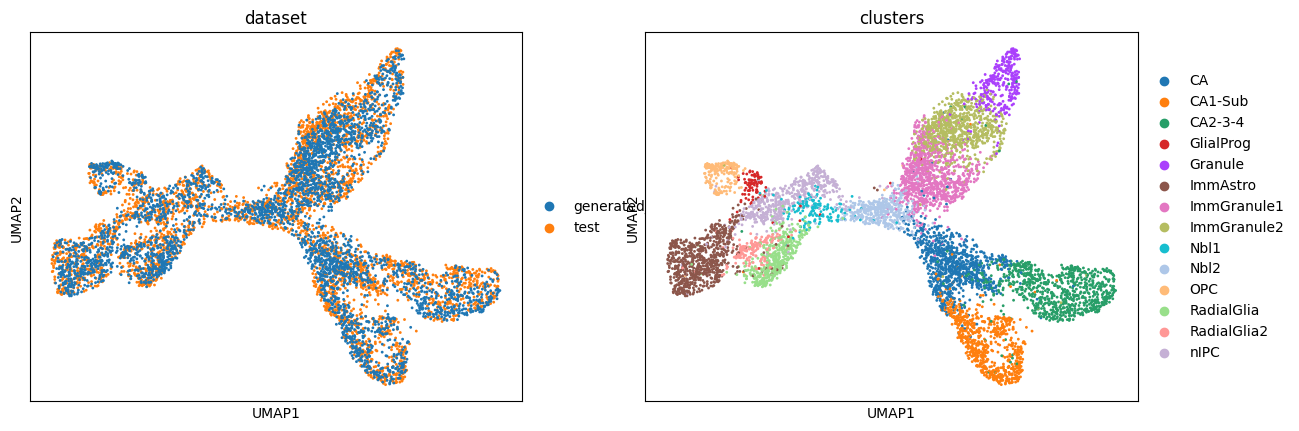

In [10]:
sc.pl.umap(
    adata_conditional,
    color=["dataset", "clusters"],
    ncols=2,
)

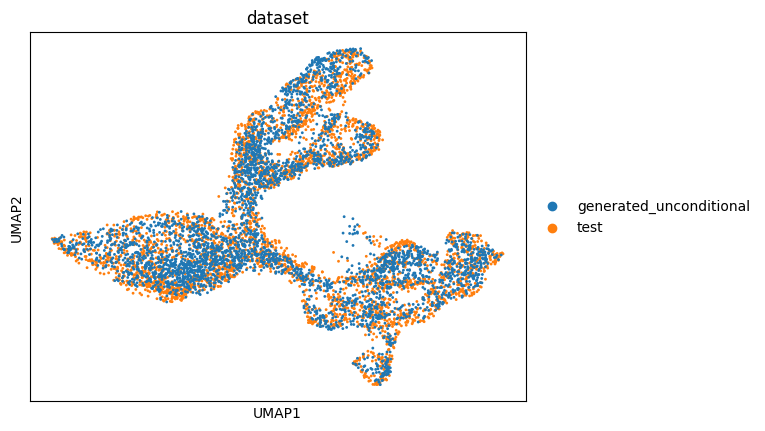

In [11]:
sc.pl.umap(adata_unconditional, color=["dataset"], ncols=2)

## Conclusions and next steps

- The notebook demonstrates end-to-end generation using the configured model and datamodule.
- Visualizations help assess similarity between generated and test data.

Next steps:
- Tune `model.module.generation_args` (e.g., `guidance_weight`) and re-run.
- Try different datasets by switching `datamodule.dataset` in the config.
- Save and version results using your preferred logger or artifact store.
